# Create frequent public transport stops analysis


This notebook describes the example for a process to retain bus stops points with frequent services in a city

### Method: Stop headway analysis using average frequencies of departure during day time

- group by service date, then count the frequencies of departure for each stop
- calculate the average headway during daytime over departure for normal weekdays
- approach taken by Carl Higgs (20200106) following [tidytransit](http://tidytransit.r-transit.org/articles/servicepatterns.html)


### Process:
1. set up study region GTFS analysis parameters (gtfs_config.py)  
2. load GTFS data into an UrbanAccess transit data frame
    - stops will be loaded limited within study region buffered bounding box
3. select a usual or representative one week during the feeds period that should fully capture the provided PT services in a city. 
    - a suitable "usual" week should contain at least 0.9 (default) of the total maximum of trips.
4. Stop headway analysis using average departure time during usual weekday (Monday-Friday) daytime (7am-7pm)


A handy guide to the format of GTFS fields is [here](https://developers.google.com/transit/gtfs/reference/#tripstxt)   
Previous working branch using SQL:

https://github.com/shiqin-liu/global-indicators/blob/phoenix/process/07_create_frequent_public_transport.ipynb  


In [19]:
#For UrbanAccess installation instructions see: https://udst.github.io/urbanaccess/installation.html

In [20]:
#conda install -c udst urbanaccess

In [21]:
import pandas as pd
import geopandas as gpd
import os
import time   
import networkx as nx
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt

import calendar
import datetime
from datetime import timedelta


import urbanaccess as ua

# module with functions to load GTFS data into dataframes
# revise based on origional load function from UrbanAccess, take out the add agency and route type features
import ua_load 

# module with functions to calculate the average headway during the timeframe over departure
import gtfs_headway_analysis as gha

from shapely.geometry import shape,Point, LineString, Polygon

%matplotlib inline


In [22]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


In [23]:
# list of global cities and its projection
cities = [{'cityname': 'adelaide', 'region': 'au', 'crs': 'epsg:7845'},
          {'cityname': 'auckland', 'region': 'nz', 'crs': 'epsg:2193'},
          {'cityname': 'baltimore', 'region': 'us', 'crs': 'epsg:32618'},
          {'cityname': 'bangkok', 'region': 'th', 'crs': 'epsg:32647'},
          {'cityname': 'barcelona', 'region': 'es', 'crs': 'epsg:25831'},
          {'cityname': 'belfast', 'region': 'gb', 'crs': 'epsg:29902'},
          {'cityname': 'bern', 'region': 'ch', 'crs': 'epsg:32633'},
          {'cityname': 'chennai', 'region': 'in', 'crs': 'epsg:32644'},
          {'cityname': 'cologne', 'region': 'de', 'crs': 'epsg:32631'},
          {'cityname': 'ghent', 'region': 'be', 'crs': 'epsg:32631'},
          {'cityname': 'graz', 'region': 'at', 'crs': 'epsg:32633'},
          {'cityname': 'hanoi', 'region': 'vn', 'crs': 'epsg:32648'},
          {'cityname': 'hong_kong', 'region': 'hk', 'crs': 'epsg:32650'},
          {'cityname': 'lisbon', 'region': 'pt', 'crs': 'epsg:3763'},
          {'cityname': 'melbourne', 'region': 'au', 'crs': 'epsg:7845'},
          {'cityname': 'mexico_city', 'region': 'mx', 'crs': 'epsg:32614'},
          {'cityname': 'odense', 'region': 'dk', 'crs': 'epsg:32632'},
          {'cityname': 'olomouc', 'region': 'cz', 'crs': 'epsg:32633'},
          {'cityname': 'phoenix', 'region': 'us', 'crs': 'epsg:32612'},
          {'cityname': 'sao_paulo', 'region': 'br', 'crs': 'epsg:32723'},
          {'cityname': 'seattle', 'region': 'us', 'crs': 'epsg:32610'},
          {'cityname': 'sydney', 'region': 'au', 'crs': 'epsg:7845'},
          {'cityname': 'valencia', 'region': 'es', 'crs': 'epsg:25830'},
          {'cityname': 'vic', 'region': 'es', 'crs': 'epsg:25831'}]

In [24]:
# get lat lon bounding box for each study region from study region input geopackage
# for plotting and for limiting the stops analysis within the study region
     
for i in range(len(cities)):
    city = cities[i]['cityname']
    region = cities[i]['region']
    crs = cities[i]['crs']
    
    geopackagePath = '../data/input/{city}_{region}_2019_1600m_buffer.gpkg'.format(
            city=city, region=region)
    # load shapefile
    shape = gpd.GeoDataFrame.from_file(geopackagePath, 
                  layer='urban_study_region')
    
    polygon = shape['geometry'].iloc[0]
    # create buffer to consider edge effect
    polygon_buffered = polygon.buffer(500)
        
    # project to lat lon
    polygon_proj = ox.projection.project_geometry(polygon_buffered, crs=crs, to_crs=None, to_latlong=True)

    # get bounding box
    bbox = polygon_proj[0].bounds
    print(city, ' : ', bbox)
    
#minx , miny , maxx , maxy

adelaide  :  (138.46098212857206, -35.15966609024628, 138.7483172991119, -34.71454282915053)
auckland  :  (174.57726564925753, -37.089137447205424, 174.98796590474333, -36.68399669533544)
baltimore  :  (-76.71732081546881, 39.197419266639976, -76.5236521818912, 39.376708110613045)
bangkok  :  (100.3242991903801, 13.581639211414096, 100.89708064810183, 13.95971650444916)
barcelona  :  (2.0822008749659653, 41.31251726667463, 2.2342770048946647, 41.47251143638445)
belfast  :  (-6.069370813429028, 54.53841202212306, -5.808356706711118, 54.66949357864951)
bern  :  (7.35925731707479, 46.91988034541113, 7.502082155046321, 46.99460688285972)
chennai  :  (80.13557688345986, 12.84745650235429, 80.3375087202582, 13.239675620841895)
cologne  :  (6.8090292419421345, 50.82712108456513, 7.150063369469329, 51.074342237096744)
ghent  :  (3.65756993174172, 50.97975642949553, 3.8406106107978766, 51.192596595895836)
graz  :  (15.37640720799714, 47.008338596794694, 15.503608232543947, 47.12801640229455)
ha

In [28]:
# set up study region GTFS config
# these gtfs parameters are defined in gtfs_config.py file
GTFS = {'seattle' : {'gtfs_filename':'gtfs_input_data/gtfs_us_seattle',
                   'gtfs_provider' : 'KingCountyMetro',
                   'gtfs_year' : '2019',
                   # define month and day for "representative period" ie. not in school time
                   'start_date_mmdd' : '20190405',
                   'end_date_mmdd' : '20190605',
                   'bbox' : (-122.44062497660697, 47.32215932339286, -122.14265080596407, 47.78244655092636),
                   'crs': 'epsg:32610',
                   # define modes for GTFS feed(s) as per agency_id codes in agency.txt below
                   'modes' : {
                       'bus' : {'route_types': [3],
                                 'peak_time' : ['07:00:00', '09:00:00'],
                                 'day_time' : ['07:00:00', '19:00:00'],
                                 'intervals': 30,
                                'agency_id': None},
                       'tram':{'route_types': [0],
                               'peak_time' : ['07:00:00', '09:00:00'],
                               'day_time' : ['07:00:00', '19:00:00'],
                               'intervals': 30,
                               'agency_id': None},
                       'train':{'route_types': [1,2],
                               'peak_time' : ['07:00:00', '09:00:00'],
                               'day_time' : ['07:00:00', '19:00:00'],
                               'intervals': 30,
                               'agency_id': None},
                       'ferry':{'route_types': [4],
                               'peak_time' : ['07:00:00', '09:00:00'],
                               'day_time' : ['07:00:00', '19:00:00'],
                               'intervals': 30,
                               'agency_id': None}
                   }
                  }
       }
                    



In [29]:
# set up a study region config to run in this notebook
city = 'seattle'

gtfsfeed_path = GTFS['{}'.format(city)]['gtfs_filename']
start_date=GTFS['{}'.format(city)]['start_date_mmdd']
end_date=GTFS['{}'.format(city)]['end_date_mmdd']

peak_hour = GTFS['{}'.format(city)]['modes']['bus']['day_time']
start_hour = peak_hour[0]
end_hour = peak_hour[1]
bbox = GTFS['{}'.format(city)]['bbox']
crs = GTFS['{}'.format(city)]['crs']


headway_intervals = GTFS['{}'.format(city)]['modes']['bus']['intervals']
route_types = GTFS['{}'.format(city)]['modes']['bus']['route_types']
agency_ids = GTFS['{}'.format(city)]['modes']['bus']['agency_id']



# Load GTFS data into an UrbanAccess transit data frame

### Using UrbanAccess as source for:
- The settings object
- The feeds object and searching for GTFS feeds
- Loading GTFS data into a UrbanAccess transit data object


In [30]:
# revise based on origional function from UrbanAccess, take out the add agency and route type features
# we may want to limit the stops within the study region bounding box for efficiency, as some feeds are regional system
loaded_feeds = ua_load.gtfsfeed_to_df(gtfsfeed_path=gtfsfeed_path, validation=True, bbox=bbox, remove_stops_outsidebbox=True)

--------------------------------
GTFS text file header whitespace check completed. Took 11.39 seconds
--------------------------------
Processing GTFS feed: gtfs_us_seattle_kingcountymetro_20190319
Records: {}
     stop_id  stop_code                                   stop_name  \
891     2201        NaN                       S Lewis St & Sumac Dr   
893     2202        NaN                    N Kelsey St & Galaxy Way   
894     2203        NaN                      Us Hwy 2 & Sr 522 Ramp   
896     2204        NaN                  Freylands Blvd & Tye St SE   
897     2205        NaN                Village Way & Sky River Pkwy   
...      ...        ...                                         ...   
7650   99479        NaN              Semanski St & Christianson Ave   
7651   99481        NaN                    Semanski St & Warner Ave   
7652   99482        NaN          School District Rd & Mcdougall Ave   
7653   99483        NaN                  SE 272nd St & 228th Ave SE   
7683   99

### The transit data object

The output is a global `urbanaccess_gtfs_df` object that can be accessed with the specified variable `loaded_feeds`. This object holds all the individual GTFS feed files aggregated together with each GTFS feed file type in separate Pandas DataFrames to represent all the loaded transit feeds in a metropolitan area. 

Quickly view the transit stop locations

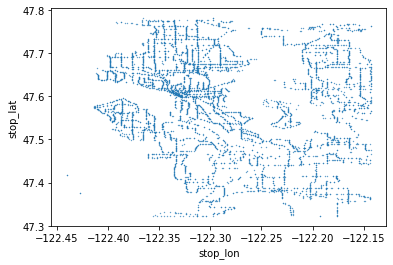

In [31]:
loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)


# Select usual and representative one week for feeds analysis


In [32]:
# drive usual week starting Monday
# ensured that all weekdays have at least 90% of the maximum number of 
# daily PT trips during the time span of the week-long extract.
daily_trip_counts = gha.get_trip_counts_per_day(loaded_feeds)


In [33]:
usual_start_date = gha.get_weekly_extract_start_date(daily_trip_counts, weekdays_at_least_of_max=0.9, start_date=start_date, end_date=end_date)
usual_start_date


Timestamp('2019-05-20 00:00:00')

In [34]:
daily_trip_counts = daily_trip_counts[(daily_trip_counts.date >= start_date) & (daily_trip_counts.date <= end_date)]

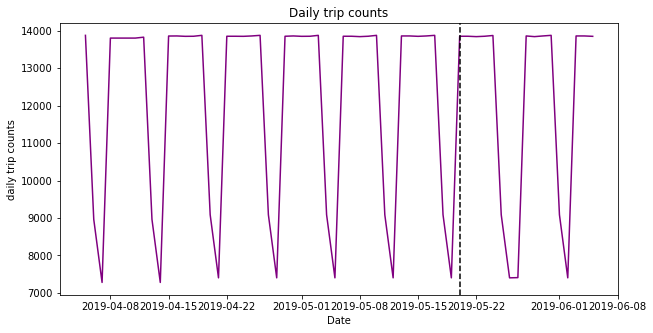

In [35]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 5))

# Add x-axis and y-axis
ax.plot(daily_trip_counts.sort_values('date')['date'],
        daily_trip_counts.sort_values('date')['trip_counts'],
        color='purple')

plt.axvline(x=usual_start_date, color='k', linestyle='--')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="daily trip counts",
       title="Daily trip counts")

plt.show()

Reference: [Kujala et. al. (2018) A collection of public transport network data sets for 25 cities](https://www.nature.com/articles/sdata201889#Sec21)  
"The dates for the temporal filtering were chosen based on the number of daily trips of the included feeds. We ensured that there was a clear weekly periodicity in the feeds, so that working days have roughly the same number of trips and that weekends have a different schedule. Then we selected the dates for the week-long and day-long extracts, where we aimed for a typical work week without major exceptions in the PT operations, such as national holidays. To this end, we ensured that all weekdays have at least 90% of the maximum number of daily PT trips during the time span of the week-long extract."

# Stop headway analysis using average departure time dur weekday daytime

- Identify feeds start and end dates that that a stop is a 30-minute frequency stop  
- group by service date, then count the frequencies of departure for each stop
- calculate the average headway during the timeframe over departure
- approach taken by Carl Higgs (20200106) following [tidytransit](http://tidytransit.r-transit.org/articles/servicepatterns.html)

In [36]:
# set the start and end date to usual week of weekday operation (Monday to Friday)
start_date = usual_start_date
end_date = usual_start_date + timedelta(4)

In [37]:
stops_headway = gha.get_hlc_stop_frequency(loaded_feeds, start_hour, end_hour, start_date, 
                           end_date, route_types, agency_ids, 
                           dow=['monday','tuesday','wednesday','thursday','friday'])

/home/jovyan/work/Documents/GitHub/global-indicators/process/GTFS_freq_stop/gtfs_headway_analysis.py:294: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  & (date_service_df['date'] <= end_date_mmdd)].drop_duplicates()


In [38]:
# select average departure headway less than or equal to maxi headway frequency intervals
stop_30_mins_headway = stops_headway[stops_headway['headway'] <= 20]

# get spatial features for freqent stops
stop_30_mins_final = pd.merge(stop_30_mins_headway, loaded_feeds.stops, how='left', on='stop_id')

# add stop id geometry
stop_30_mins_final['geometry'] = stop_30_mins_final.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
stop_30_mins_final = gpd.GeoDataFrame(stop_30_mins_final)

In [39]:
len(stop_30_mins_final)

2824

# Plot all PT stop and freqent PT bus stops

In [43]:
# get the study region boundary gdf
city = 'seattle'
region = 'us'
geopackagePath = '../data/input/{city}_{region}_2019_1600m_buffer.gpkg'.format(
        city=city, region=region)

# load shapefile and project to latlong for plotting with PT points
shape = gpd.GeoDataFrame.from_file(geopackagePath, 
              layer='urban_study_region')
shape_proj = ox.projection.project_gdf(shape, to_crs=None, to_latlong=True)


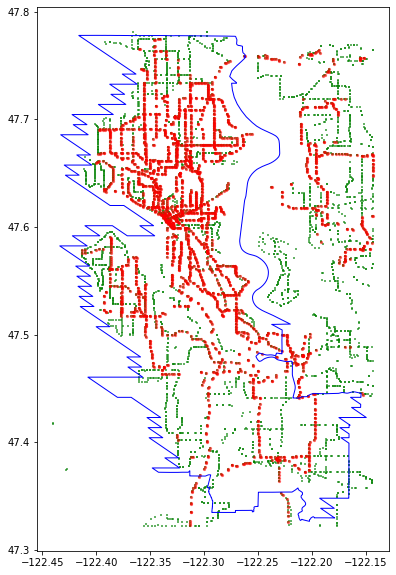

In [44]:
# set spatial geometry for all stops 
loaded_feeds.stops['geometry'] = loaded_feeds.stops.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
all_stops_gdf = gpd.GeoDataFrame(loaded_feeds.stops)

# plot the stops
fig, ax = plt.subplots(figsize=(10, 10))
ax = all_stops_gdf.plot(ax=ax, color='green', marker='+', markersize=5, alpha=0.6)
ax = stop_30_mins_final.plot(ax=ax, color='red', marker='o', markersize=5, alpha=0.5)
ax = shape_proj.plot(ax=ax, color='none', edgecolor='blue')

#ax.set_axis_off()

plt.show()